# Unified image generation using OmniGen and OpenVINO

OmniGen is a unified image generation model that can generate a wide range of images from multi-modal prompts. It is designed to be simple, flexible, and easy to use. Existing image generation models often require loading several additional network modules (such as ControlNet, IP-Adapter, Reference-Net, etc.) and performing extra preprocessing steps (e.g., face detection, pose estimation, cropping, etc.) to generate a satisfactory image. OmniGen can generate various images directly through arbitrarily multi-modal instructions without additional plugins and operations.  it can automatically identify the features (e.g., required object, human pose, depth mapping) in input images according to the text prompt.

Here are the illustrations of OmniGen's capabilities:

* You can control the image generation flexibly via OmniGen


  ![exanple_1.png](https://github.com/VectorSpaceLab/OmniGen/raw/main/imgs/demo_cases.png)
  
* Referring Expression Generation: You can input multiple images and use simple, general language to refer to the objects within those images. OmniGen can automatically recognize the necessary objects in each image and generate new images based on them. No additional operations, such as image cropping or face detection, are required.

  ![example_2.png](https://github.com/VectorSpaceLab/OmniGen/raw/main/imgs/referring.png)


You can find more details about a model on [project page](https://vectorspacelab.github.io/OmniGen/), [paper](https://arxiv.org/pdf/2409.11340v1), [original repository](https://github.com/VectorSpaceLab/OmniGen).

This tutorial considers how to run and optimize OmniGen using OpenVINO.

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Convert and Optimize model](#Convert-and-Optimize-model)
    - [Compress model weights](#Compress-model-weights)
- [Prepare inference pipeline](#Prepare-inference-pipeline)
    - [Select inference device](#Select-inference-device)
- [Run model inference](#Run-model-inference)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/omnigen/omnigen.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [1]:
import requests
from pathlib import Path

helper_files = ["ov_omnigen_helper.py", "gradio_helper.py"]
utility_files = ["notebook_utils.py", "cmd_helper.py"]


for utility in utility_files:
    if not Path(utility).exists():
        r = requests.get(f"https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/{utility}")
        with open(utility, "w") as f:
            f.write(r.text)

for helper in helper_files:
    if not Path(helper).exists():
        r = requests.get(f"https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/omnigen/{helper}")
        with open(helper, "w") as f:
            f.write(r.text)

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("omnigen.ipynb")

In [2]:
import platform

%pip install -q "torch>=2.2" "transformers>=4.45.2" "accelerate>=0.26.1" "diffusers>=0.30.3" "timm" "peft>=0.9.0" "safetensors" "pillow" "opencv-python" "tqdm" "gradio>=4.19" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "openvino>=2024.6.0" "nncf>=2.14"

if platform.system() == "Darwin":
    %pip install -q "numpy<2.0.0"

In [3]:
from cmd_helper import clone_repo

clone_repo("https://github.com/VectorSpaceLab/OmniGen.git")

PosixPath('OmniGen')

## Convert and Optimize model
[back to top ⬆️](#Table-of-contents:)


For starting work with OpenVINO we should convert models to OpenVINO Intermediate Representation format first.

[OpenVINO model conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html#convert-a-model-with-python-convert-model) should be used for these purposes. `ov.convert_model` function accepts original model instance and example input for tracing and returns `ov.Model` representing this model in OpenVINO framework. The converted model can be used for saving on disk using `ov.save_model` function or directly loading on the device using `core.complie_model`.

![](https://vectorspacelab.github.io/OmniGen/img/framework.png)
Model consists of 2 key components:

* **Transformer*** is Phi3-based model that gradually denoising input latents guided by timestep, images and text prompt embeddings.
* **VAE** for encoding input images to latent space and decoding generation results to image space

For convenience we will use `convert_omnigen_model` function `ov_omnigen_helper.py`.

In [4]:
from ov_omnigen_helper import convert_omingen_model

# Uncomment the line to see model conversion code
# ??convert_omnigen_model

2024-12-27 12:58:09.587676: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-27 12:58:09.600460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735289889.615212  147835 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735289889.619665  147835 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 12:58:09.635197: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


### Compress model weights
[back to top ⬆️](#Table-of-contents:)


For reducing memory consumption, weights compression optimization can be applied using [NNCF](https://github.com/openvinotoolkit/nncf). Weight compression aims to reduce the memory footprint of a model. It can also lead to significant performance improvement for large memory-bound models, such as Large Language Models (LLMs).

 LLMs and other models, which require extensive memory to store the weights during inference, can benefit from weight compression in the following ways:

* enabling the inference of exceptionally large models that cannot be accommodated in the memory of the device;

* improving the inference performance of the models by reducing the latency of the memory access when computing the operations with weights, for example, Linear layers.

[Neural Network Compression Framework (NNCF)](https://github.com/openvinotoolkit/nncf) provides 4-bit / 8-bit mixed weight quantization as a compression method primarily designed to optimize LLMs. The main difference between weights compression and full model quantization (post-training quantization) is that activations remain floating-point in the case of weights compression which leads to a better accuracy. Weight compression for LLMs provides a solid inference performance improvement which is on par with the performance of the full model quantization. In addition, weight compression is data-free and does not require a calibration dataset, making it easy to use.

`nncf.compress_weights` function can be used for performing weights compression. The function accepts an OpenVINO model and other compression parameters. Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality.

More details about weights compression, can be found in [OpenVINO documentation](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html).


In [5]:
import nncf

compression_configuration = {
    "mode": nncf.CompressWeightsMode.INT4_ASYM,
    "group_size": 64,
    "ratio": 1.0,
}

model_id = "Shitao/OmniGen-v1"
model_path = Path("omnigen_ov")

convert_omingen_model(model_id, model_path, compression_configuration)

Model already converted and can be found in omnigen_ov


## Prepare inference pipeline
[back to top ⬆️](#Table-of-contents:)


`ov_omnigen_helper.py` contains `OVOmniGenPipeline` that loads OpenVINO OmniGen models and runs inference using a specified device. Its usage is similar to the original `OmniGenPipeline`. 

### Select inference device
[back to top ⬆️](#Table-of-contents:)

In [6]:
from notebook_utils import device_widget

device = device_widget("CPU", ["NPU"])

device

Dropdown(description='Device:', options=('CPU', 'AUTO'), value='CPU')

In [ ]:
from ov_omnigen_helper import OVOmniGenPipeline

# Uncomment this line to see model inference pipeline
# ??OVOmniGenPipeliine

In [7]:
pipe = OVOmniGenPipeline(model_path, device.value)

## Run model inference
[back to top ⬆️](#Table-of-contents:)

  0%|          | 0/25 [00:00<?, ?it/s]

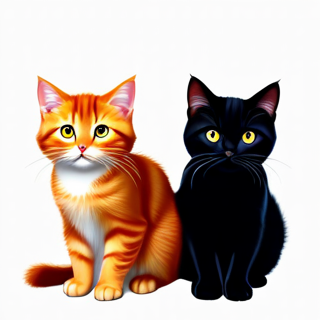

In [8]:
images = pipe(
    prompt="Two cute cats, one of them is ginger and another one is black, quality details, hyper realistic, high definition, photorealistic",
    height=320,
    width=320,
    guidance_scale=2.5,
    seed=0,
    max_input_image_size=320,
    num_inference_steps=25,
)
images[0]

In [9]:
images[0].save("cats.png")

  0%|          | 0/30 [00:00<?, ?it/s]

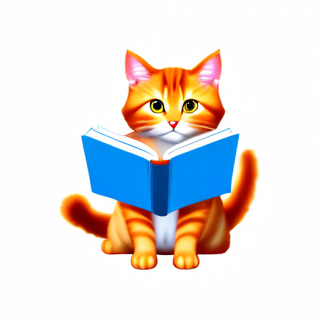

In [10]:
images = pipe(
    prompt="A cat is reading a blue book. The cat is the left cat in <img><|image_1|></img>.",
    input_images=["cats.png"],
    height=320,
    width=320,
    guidance_scale=2.5,
    img_guidance_scale=1.6,
    seed=0,
    max_input_image_size=320,
    num_inference_steps=30,
)
images[0]

## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from gradio_helper import make_demo

demo = make_demo(pipe)

try:
    demo.launch(debug=True, height=800)
except Exception:
    demo.launch(debug=True, share=True, height=800)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/